**Create quantizised version of GPT-2 and save the memory =)**

Egor Shvetsov, Viktoriia Chekalina

In [2]:
! pip install transformers

In [3]:
device = 'cuda:0'

## Class Quantizator

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

![](https://drive.google.com/uc?export=view&id=1qG2l66t1tZNk-V-CQs80e-DiyevAF2ea)

In [6]:
class Quantizer(nn.Module):
    def __init__(self, bit):

        super(Quantizer, self).__init__()
        self.bit = bit
        self.thd_neg = -(2 ** (bit - 1))
        self.thd_pos = 2 ** (bit - 1) - 1
        self.s = nn.Parameter(torch.ones(1))

    def init_from(self, x):
        s = (x.max() - x.min()) / (self.thd_pos - self.thd_neg )
        self.s = nn.Parameter(s)

    def skip_grad_scale(self,x, scale):
        y = x
        y_grad = x * scale
        return (y - y_grad).detach() + y_grad

    def round_pass(self, x): # round ans clip are not differentiable
        y = x.round()
        y_grad = x
        return (y - y_grad).detach() + y_grad

    def forward(self, x):
        if self.bit >= 32:
            return x

        s_grad_scale = 1.0 / ((self.thd_pos * x.numel()) ** 0.5) # is not diff, skip_grad_scale

        device = x.device

        s_scale = self.skip_grad_scale(self.s, s_grad_scale).to(device)

        x = x / (s_scale) # go to new space
        x = torch.clamp(x, self.thd_neg, self.thd_pos) # clip is not diff, round_pass
        x = self.round_pass(x) #go back
        x = x * (s_scale)
        return x

In [7]:
vector =(np.arange(-10, 10, 1))**2

In [8]:
vector

array([100,  81,  64,  49,  36,  25,  16,   9,   4,   1,   0,   1,   4,
         9,  16,  25,  36,  49,  64,  81])

In [9]:
quantizer = Quantizer(4)
vector = torch.tensor(vector)
quantizer.init_from(vector)
quantizer(vector).detach().numpy()

array([46.666664 , 46.666664 , 46.666664 , 46.666664 , 33.333332 ,
       26.666666 , 13.333333 ,  6.6666665,  6.6666665,  0.       ,
        0.       ,  0.       ,  6.6666665,  6.6666665, 13.333333 ,
       26.666666 , 33.333332 , 46.666664 , 46.666664 , 46.666664 ],
      dtype=float32)

In [10]:
quantizer.s

Parameter containing:
tensor(6.6667, requires_grad=True)

In [11]:
quantizer = Quantizer(16)
vector = torch.tensor(vector)
quantizer.init_from(vector)
quantizer(vector).detach().numpy()

<ipython-input-11-f6c3db215e95>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vector = torch.tensor(vector)


array([49.999237  , 49.999237  , 49.999237  , 48.99977   , 36.00061   ,
       25.000381  , 16.00061   ,  8.999771  ,  3.9993896 ,  0.99946594,
        0.        ,  0.99946594,  3.9993896 ,  8.999771  , 16.00061   ,
       25.000381  , 36.00061   , 48.99977   , 49.999237  , 49.999237  ],
      dtype=float32)

<Figure size 1000x700 with 0 Axes>

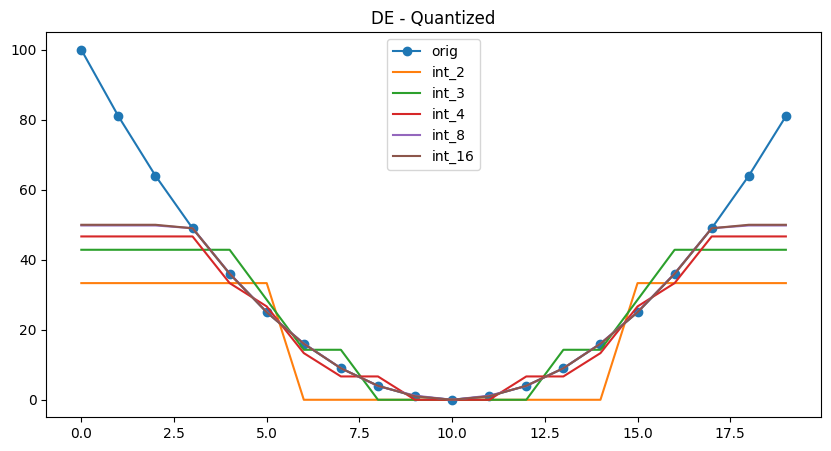

In [12]:
vector =(np.arange(-10, 10, 1))**2

vector = torch.tensor(vector)

plt.figure(figsize=(10,7))

f = plt.figure(figsize = (10, 5))

plt.plot(range(len(vector)), vector,label='orig', marker='o')
for bit in [2,3,4, 8, 16]:
    quantizer = Quantizer(bit)
    quantizer.init_from(vector) # define step
    dequantized = quantizer(vector) #

    dequantized = dequantized.detach().numpy()

    plt.plot(range(len(vector)),dequantized,label=f'int_{bit}')

plt.title('DE - Quantized');
plt.legend();

In [16]:
class QALinear(nn.Module):
    def __init__(self, fc_w, fc_b, bit):
        super(QALinear, self).__init__()
        self.bit = bit
        self.in_features, self.out_features = fc_w.shape
        self.fc = nn.Linear(in_features = self.in_features,
                      out_features = self.out_features,
                      bias = True)
        self.fc.weight = torch.nn.Parameter(torch.t(fc_w))
        self.fc.bias = fc_b
        self.define_q_fucntions(self.bit)


    # can be used to modify bits during the training
    def define_q_fucntions(self, bit):
        self.quantizer_act = Quantizer(bit)
        self.quantizer_weigh = Quantizer(bit)
        self.quantizer_weigh.init_from(self.fc.weight)

        self.quantizer_bias = Quantizer(bit)

    def forward(self, input_x):
        quantized_weight = self.quantizer_weigh(self.fc.weight)
        quantized_bias = self.quantizer_weigh(self.fc.bias)
        quantized_act = self.quantizer_act(input_x)
        out = nn.functional.linear(quantized_act, quantized_weight, bias=quantized_bias) #torch.nn.functional.linear(input, weight, bias)
        return out

# Transformer-based model quantization

### GPT-2 quantization pipeline

1) Extract fully-connected (transformers.conv1D()) from pretrained GPT-2

2) Create quantized QALinear object over it

3) Replace initial fully-connected layer with quantized layer

4) Fine-tune model to recover performance degradation


## Let's go through all of the stages in the pipeline

In [17]:
import numpy as np

In [18]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

# Initializing a GPT2 configuration
configuration = GPT2Config()

device = 'cuda'


model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
outt = model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

We will validate a pre-trained language GPT-2 model on a validation part **Wikitext-103** dataset.

To create a validation dataset we should:
    
- download archieved dataset
- extract it
- wrap tran and test parts in TextDataset and further Dataloader class

In [55]:
!unzip wikitext-103.zip
!ls

Archive:  wikitext-103.zip
   creating: wikitext-103/
  inflating: __MACOSX/._wikitext-103  
  inflating: wikitext-103/wiki.test.tokens  
  inflating: __MACOSX/wikitext-103/._wiki.test.tokens  
  inflating: wikitext-103/wiki.valid.tokens  
  inflating: __MACOSX/wikitext-103/._wiki.valid.tokens  
  inflating: wikitext-103/wiki.train.tokens  
  inflating: __MACOSX/wikitext-103/._wiki.train.tokens  
__MACOSX  sample_data  wikitext-103  wikitext-103.zip


In [56]:
from torch.utils.data import DataLoader, RandomSampler
from transformers import GPT2Tokenizer
from transformers import TextDataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")


dataset_valid = TextDataset(tokenizer=tokenizer,
                                file_path="/content/wikitext-103/wiki.valid.tokens",
                                block_size=512)

dataset_test = TextDataset(tokenizer=tokenizer,
                                file_path="/content/wikitext-103/wiki.test.tokens", block_size=512)
len(dataset_valid), len(dataset_test)

eval_dataloader = DataLoader(dataset_valid, batch_size=10)

Validate model and calculate a perplexity:

In [59]:
from tqdm import tqdm
model.eval()
import torch

device = 'cuda'

def evaluate(model):
    losses = []
    eval_loss = 0.0
    perplexity = 0.0
    nb_eval_steps = 0
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
            perplexity += torch.exp(torch.tensor(eval_loss))
            losses.append(eval_loss)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    perplexity = torch.exp(torch.tensor(eval_loss))
    perplexity = perplexity
    return perplexity

In [60]:
perplexity = evaluate(model.to(device))
perplexity

Evaluating: 100%|██████████| 49/49 [00:21<00:00,  2.27it/s]


tensor(35.1143)

In [61]:
model.transformer.h[1].mlp.c_fc.weight.shape

torch.Size([768, 3072])

Let's generate text to ensure that model is good.

In [62]:
seq_len = 512

In [63]:
i = 0
for batch_idx, sample in tqdm(enumerate(eval_dataloader)):
    input_ids, label_ids = sample[0][:seq_len - 1], sample[0][1:seq_len]
    input_ids = input_ids.to(device=device)
    label_ids = label_ids.to(device=device)
    outputs = model(input_ids)
    print ("\n")
    print("input_ids[0][-20:]", tokenizer.decode(input_ids[-10:]))
    print ("\n")
    print("label_ids[0][-21:]", tokenizer.decode(input_ids[-9:]))
    print ("\n")
    print("output", tokenizer.decode(outputs.logits.argmax(dim=-1)[-10:]))
    #print("GENERATED", tokenizer.decode(outputs.logits.argmax(dim=-1)[0][-1:]))
    print("\n\n\n")
    i += 1
    if i > 10: break
    print ("\n\n")

2it [00:00, 18.52it/s]



input_ids[0][-20:]  lobster , Homarus americanus . The two species


label_ids[0][-21:]  , Homarus americanus . The two species


output  , Harus gamanus . It American species are









input_ids[0][-20:]  National Forest . The east end of M @-


label_ids[0][-21:]  Forest . The east end of M @-


output  Forest . The highwaybound of the @-@









input_ids[0][-20:]  as a liaison between the organizations . Plans were underway


label_ids[0][-21:]  a liaison between the organizations . Plans were underway


output  a liaison between the Meridian and  for made to









input_ids[0][-20:]  @-@ seat auditorium for live performances ,


label_ids[0][-21:] -@ seat auditorium for live performances ,


output ,@ and,ium, the performances, is











8it [00:00, 22.02it/s]

input_ids[0][-20:]  @,@ 
 Fred and Al Key ,


label_ids[0][-21:] ,@ 
 Fred and Al Key ,


output ,@ 

rick Mary <es the









input_ids[0][-20:] le was the villain . 
 
 =


label_ids[0][-21:]  was the villain . 
 
 =


output  is a main. 
 "
 = =









input_ids[0][-20:] @ northwesterly track in response to a


label_ids[0][-21:]  northwesterly track in response to a


output  orientationwardesterly direction, the to the strong









input_ids[0][-20:]  is shown standing in a cage opposite to a number


label_ids[0][-21:]  shown standing in a cage opposite to a number


output  singing dancing in front white with the the man of









input_ids[0][-20:] -@ lap sprint , Richmond competed in a three


label_ids[0][-21:] @ lap sprint , Richmond competed in a three


output @ race , , Richmond took in the race @











10it [00:00, 20.01it/s]

input_ids[0][-20:]  well @-@ being of ranchers . In


label_ids[0][-21:]  @-@ being of ranchers . In


output --@ needs of localhers .  addition









input_ids[0][-20:]  for their first road win in Illinois since 1995 .


label_ids[0][-21:]  their first road win in Illinois since 1995 .


output  the first Big win of four ' beating . On






In [64]:
for i in [6, 8, 9, 10, 11]:
    # fc part
    fc_w = model.transformer.h[i].mlp.c_fc
    fp_w = model.transformer.h[i].mlp.c_proj
    model.transformer.h[i].mlp.c_fc = QALinear(fc_w.weight, fc_w.bias, 4)
    model.transformer.h[i].mlp.c_proj = QALinear(fp_w.weight, fp_w.bias, 4)

In [65]:
perplexity = evaluate(model)
perplexity

Evaluating: 100%|██████████| 49/49 [00:20<00:00,  2.38it/s]


tensor(141.6086)